In [8]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim



class ConditionalGRU(nn.Module):
    """Reference: https://github.com/Maluuba/gensen/blob/master/models.py
    """

    def __init__(self, input_dim, hidden_dim, dropout=0):
        super(ConditionalGRU, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim

        self.input_weights = nn.Linear(self.input_dim, 3 * self.hidden_dim)
        self.hidden_weights = nn.Linear(self.hidden_dim, 3 * self.hidden_dim)
        self.peep_weights = nn.Linear(self.hidden_dim, 3 * self.hidden_dim)

        self.reset_parameters()    # TODO:Check if this is necessary

    def reset_parameters(self):
        stdv = 1.0 / math.sqrt(self.hidden_dim)
        for weight in self.parameters():
            weight.data.uniform_(-stdv, stdv)

    def forward(self, input, hidden, ctx):
        def recurrence(input, hidden, ctx):
            """Recurrence helper
            """
            input_gate = self.input_weights(input)
            hidden_gate = self.hidden_weights(hidden)
            peep_gate = self.peep_weights(ctx)
            i_r, i_i, i_n = input_gate.chunk(3, 1)
            h_r, h_i, h_n = hidden_gate.chunk(3, 1)
            p_r, p_i, p_n = peep_gate.chunk(3, 1)
            resetgate = F.sigmoid(i_r + h_r + p_r)
            inputgate = F.sigmoid(i_i + h_i + p_i)
            newgate = F.tanh(i_n + resetgate * h_n + p_n)
            # hy = newgate + inputgate * (hidden - newgate)
            hy = hidden - inputgate * (hidden - newgate)     # Revision: https://github.com/Maluuba/gensen/issues/5

            return hy
        

        output = []
        steps = range(input.size(0))
        for i in steps:
            hidden = recurrence(input[i], hidden, ctx)
            if isinstance(hidden, tuple):
                output.append(hidden[0])
            else:
                output.append(hidden)

        output = torch.cat(output, 0).view(input.size(0), *output[0].size())
        return output, hidden


class Speech2Vec(nn.Module):
    """Speech2Vec implementation, inspired by Earth Species Project
    https://github.com/earthspecies/unsupervised-speech-translation/blob/main/unsup_st/speech2vec.py
    """
    def __init__(self, input_dim=13, hidden_dim=50, window_sz=3):
        super(Speech2Vec, self).__init__()
        self.window_sz = window_sz
        
        self.encoder = nn.GRU(input_size=input_dim,
                              hidden_size=hidden_dim, 
                              bidirectional=True,
                              bias=False)

        self.projection = nn.Linear(2 * hidden_dim, hidden_dim)
        
        self.decoders = nn.ModuleList(ConditionalGRU(input_dim=input_dim,
                                                     hidden_dim=hidden_dim,
                                                     dropout=0)
                                      for _ in range(2 * window_sz))

        self.head = nn.Linear(hidden_dim, input_dim)


    def forward(self, x_n, xs_k):
        x_n = nn.utils.rnn.pack_sequence(x_n, enforce_sorted=False)
        
        _, h_n = self.encoder(x_n)
        h_n = torch.cat((h_n[0], h_n[1]), dim=1)

        z_n = self.projection(h_n)

        ys_k = []
            
        for k in range(2 * self.window_sz):
            x_k = nn.utils.rnn.pad_sequence(xs_k[k])
            # h_k, (_, _) = self.decoders[k](x_k[: -1])
            
            out_k, _ = self.decoders[k](x_k[: -1], z_n, z_n)
            # print(f"out_n: {out_k.shape}")
            y_k = self.head(out_k)
            ys_k.append(y_k)
        
        return ys_k
            

In [9]:
from dataset import *

In [10]:
import matplotlib.pyplot as plt
plt.imshow(model.tmp.detach().numpy()[-1, :, :50])

AttributeError: 'Speech2Vec' object has no attribute 'tmp'

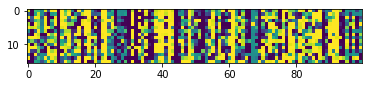

In [17]:
plt.imshow(model.h_n.detach().numpy())

In [41]:
model = Speech2Vec()

dataset = LibriSpeechDataset('data/', 'data_mapping/', window_sz=3)
dataloader = DataLoader(dataset, batch_size=16, collate_fn=dataset.pad_collate, shuffle=True)
iter_dataloader = iter(dataloader)

100%|█████████████████████████████████████████| 87/87 [00:00<00:00, 6868.66it/s]


In [42]:
src, tgts, src_word, tgt_words = next(iter_dataloader)


In [43]:
pred = model(src, tgts)

/Users/yjang43/miniconda3/envs/ml/lib/python3.8/site-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/Users/yjang43/miniconda3/envs/ml/lib/python3.8/site-packages/torch/nn/functional.py:1795: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


In [44]:
from dataset import *

criterion = nn.MSELoss()
optimizer = optim.Adam(params=model.parameters(), lr=1e-3)

In [49]:
losses = []
window_sz = 3

for idx, batch in enumerate(dataloader):
    src, tgts, _, _ = batch
    optimizer.zero_grad()
    pred = model(src, tgts)

    loss = 0
    for i in range(2 * window_sz):
        loss += criterion(pred[i], nn.utils.rnn.pad_sequence(tgts[i])[1: ])
    
    loss.backward()
    optimizer.step()
    
    loss_item = loss.item()
    if (idx + 1) % 10 == 0:
        print(loss_item)
    losses.append(loss_item)
    if idx == 500:
        break
    

593.4263305664062
570.8076171875
584.8240356445312
508.6585693359375
488.059814453125
586.1152954101562
461.2074279785156
504.1485900878906
478.08880615234375
483.2682800292969
419.8824462890625
471.4707946777344
447.8199157714844
434.62884521484375
493.72467041015625
489.2823486328125
433.97686767578125
456.89410400390625
459.65252685546875
408.5720520019531
395.37677001953125
437.0057067871094
409.5643005371094
342.5888671875
368.9610595703125
409.7039489746094
390.1936950683594
406.8690185546875
315.5923767089844
372.154541015625
410.75970458984375
393.5765075683594
367.03985595703125
354.0914611816406
313.0322570800781
402.222412109375
334.51953125
359.559814453125
323.21392822265625
308.3543701171875
325.3252868652344
384.6153869628906
347.89959716796875
330.470947265625
325.0906982421875
386.3180236816406
285.2734069824219
308.30133056640625
318.6116943359375
321.0984802246094


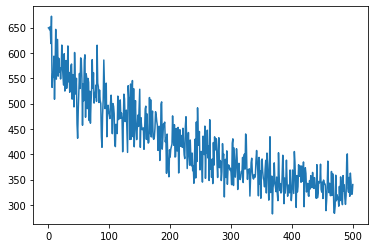

In [50]:
import matplotlib.pyplot as plt

plt.plot(losses)